In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class DynaQ:
    """ Dyna-Q算法：结合真实交互与模拟回放，提升学习效率 """
    def __init__(self,
                 ncol,
                 nrow,
                 epsilon,
                 alpha,
                 gamma,
                 n_planning,
                 n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化 Q(s,a) 表为 0
        self.n_action = n_action  # 动作数量（如上下左右）
        self.alpha = alpha  # 学习率：控制 Q 值更新幅度
        self.gamma = gamma  # 折扣因子：权衡未来回报的重要性
        self.epsilon = epsilon  # ε-贪婪策略中的探索率（探索 vs 利用）

        self.n_planning = n_planning  # 每次真实交互后，进行多少次“模拟更新”
        self.model = dict()  # 模型用于保存环境的“记忆”，键为 (s, a)，值为 (r, s')
    
    def take_action(self, state):
        """ ε-贪婪策略选动作 """
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)  # 探索：随机选一个动作
        else:
            action = np.argmax(self.Q_table[state])    # 利用：选 Q 值最大的动作
        return action

    def q_learning(self, s0, a0, r, s1):
        """ 标准 Q-learning 更新规则：用于真实和模拟更新 """
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

    def update(self, s0, a0, r, s1):
        """
        Dyna-Q 核心更新步骤：
        1. 用真实环境反馈 (s0, a0, r, s1) 做一次 Q-learning 更新
        2. 存入模型：用于后续模拟
        3. 执行 n_planning 次模拟交互，提升学习效率
        """
        # Step 1: 用真实数据做 Q-learning 更新
        self.q_learning(s0, a0, r, s1)

        # Step 2: 记忆这次真实交互，添加到模型中
        self.model[(s0, a0)] = (r, s1)

        # Step 3: 模拟交互（从记忆中随机抽样并更新）
        for _ in range(self.n_planning):
            (s, a), (r_sim, s_next_sim) = random.choice(list(self.model.items()))
            self.q_learning(s, a, r_sim, s_next_sim)

In [11]:
def DynaQ_CliffWalking(n_planning):
    # 设置 Cliff Walking 环境的网格大小
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)

    # 初始化超参数
    epsilon = 0.01       # 探索率（几乎是贪婪策略）
    alpha = 0.1          # 学习率
    gamma = 0.9          # 折扣因子
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)  # 创建 Dyna-Q 智能体

    num_episodes = 5000   # 总共执行 300 个 episode（完整的序列）

    return_list = []     # 用于记录每个 episode 的总回报

    for i in range(10):  # 把 300 个 episode 分成 10 组（每组 50 次）
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0      # 当前 episode 的累积回报
                state = env.reset()     # 初始化环境，获取初始状态
                done = False

                # 每个 episode 内循环直到达到终止状态
                while not done:
                    action = agent.take_action(state)              # 根据当前策略选择动作
                    next_state, reward, done = env.step(action)   # 执行动作，获取下一状态和奖励
                    episode_return += reward                      # 累加回报
                    agent.update(state, action, reward, next_state)  # Dyna-Q更新：Q学习 + 模拟学习
                    state = next_state                            # 更新当前状态

                return_list.append(episode_return)  # 存储该条 episode 的回报

                # 每 10 个 episode 打印一次平均回报
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])  # 打印最近 10 个回报的平均值
                    })
                pbar.update(1)  # 更新进度条

    return return_list  # 返回所有 episode 的回报，用于画图或分析

![planning](pic/6_planning.png)


Q-planning步数为：0


Iteration 9: 100%|██████████| 500/500 [00:00<00:00, 5171.97it/s, episode=5000, return=-13.000] 


Q-planning步数为：2


Iteration 9: 100%|██████████| 500/500 [00:00<00:00, 5069.76it/s, episode=5000, return=-21.700]


Q-planning步数为：20


Iteration 9: 100%|██████████| 500/500 [00:00<00:00, 1065.49it/s, episode=5000, return=-13.100]


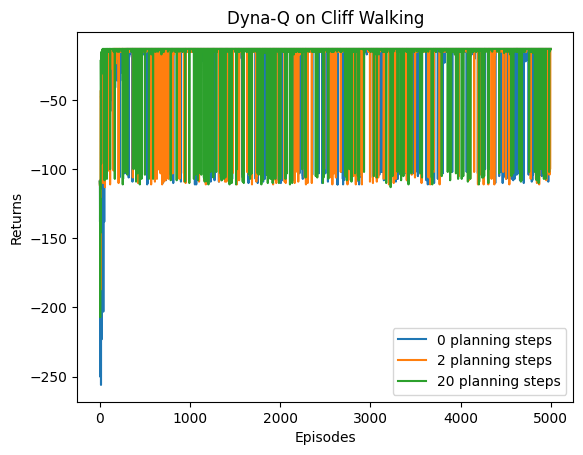

In [12]:
# 设置随机种子，保证实验结果可复现
np.random.seed(0)
random.seed(0)
# 设置三个不同的 planning 次数：0（纯Q-learning）、2、20，用于对比实验
n_planning_list = [0, 2, 20]

for n_planning in n_planning_list:  # 遍历不同的 planning 次数
    print('Q-planning步数为：%d' % n_planning)  # 打印当前 planning 步数
    time.sleep(0.5)  # 稍作延迟，美化输出体验

    return_list = DynaQ_CliffWalking(n_planning)  # 调用训练函数，获得每个 episode 的回报
    episodes_list = list(range(len(return_list)))  # 构造 x 轴：episode 序号

    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')  # 绘制每条曲线，对应不同 n_planning 值

plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()


为什么在 300 时有效，在 5000 时不明显？  

1. Dyna-Q 的强项是“加速前期收敛”  
	•	它通过模型模拟的数据，提前让 Q 值“见过”更多状态-动作对。  
	•	在训练早期（如前几十或上百个 episode），真实经验不够，planning 就特别有用。  

到了 5000，所有状态-动作都已经访问多次，即使没有 planning，Q-learning 也能补回来。此时 Dyna-Q 模拟带来的优势就被稀释了。  